In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#
from PIL import ImageDraw
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, TimeDistributed, Flatten, Dense, Dropout

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Hyper parameters


In [2]:
hyper_params = {"img_size": 500,
                "feature_map_shape": 31,
                "anchor_ratios": [1., 2., 1./2.],
                "anchor_scales": [128, 256, 512],
                "pre_nms_topn": 1000,
                "train_nms_topn": 256,
                "test_nms_topn": 16,
                "nms_iou_threshold": 0.7,
                "total_pos_bboxes": 128,
                "total_neg_bboxes": 128,
                "variances": [0.1, 0.1, 0.2, 0.2],
                "pos_threshold" : 0.6,
                "neg_threshold" : 0.25,
                "batch_size" : 4,
                "pooling_size": (7,7),
                "background" : False,
                "dtn_with_binary" : False,
                "nms_by_class" : False
                }
hyper_params['anchor_count'] = len(hyper_params['anchor_ratios']) * len(hyper_params['anchor_scales'])
#
batch_size = hyper_params['batch_size']
img_size = hyper_params["img_size"]
#
info_dir = r"/content/drive/MyDrive/faster_rcnn"
info = np.load(info_dir + "/info.npy", allow_pickle=True)

labels = info[0]["labels"]
labels = ["bg"] + labels

hyper_params["total_labels"] = len(labels)

## Data import


In [3]:
test_dir = r"/content/drive/MyDrive/faster_rcnn/"

test_file_name = ['001138', '004945', '005479', '005935', '009125', '009936']
batch_data = np.array([np.load(test_dir + test_file_name[i] + ".npy", allow_pickle=True) for i in range(batch_size)])

print('image shape:', batch_data[0,0].shape)
print('\ngt_boxes shape:',batch_data[0,1].shape)
print(batch_data[0,1])
print('\ngt_labels shape:',batch_data[0,2].shape)
print(batch_data[0,2])

image shape: (375, 500, 3)

gt_boxes shape: (6, 4)
[[0.49066666 0.556      0.776      0.702     ]
 [0.52       0.3        0.81333333 0.456     ]
 [0.67733335 0.288      0.9813333  0.434     ]
 [0.4        0.514      0.512      0.584     ]
 [0.416      0.286      0.54933333 0.38      ]
 [0.43466666 0.002      0.5786667  0.052     ]]

gt_labels shape: (6,)
[ 8  8  8 19 19 19]


## Preprocessing


In [4]:
def preprocessing(data, batch_size, final_height, final_width, evaluate):
    img_ = data[:,0]
    gt_boxes_ = data[:,1]
    gt_labels_ = data[:,2]
    is_difficult_ = data[:,3]

    for i in range(batch_size):
        
        if evaluate:
            not_diff = np.logical_not(is_difficult_[i])
            gt_boxes_[i] = gt_boxes_[i][not_diff]
            gt_labels_[i] = gt_labels_[i][not_diff]

        gt_boxes_[i] = tf.cast(gt_boxes_[i], tf.float32)
        gt_labels_[i] = tf.cast(gt_labels_[i] + 1, tf.int32)

        img_[i] = tf.image.convert_image_dtype(img_[i], tf.float32)
        img_[i] = tf.image.resize(img_[i], (final_height, final_width))

        img_[i] = tf.reshape(img_[i], shape=(1, final_height, final_width, 3))
        gt_boxes_[i] = tf.reshape(gt_boxes_[i], shape=(1, gt_boxes_[i].shape[0], 4))
        gt_labels_[i] = tf.reshape(gt_labels_[i], shape=(1, gt_labels_[i].shape[0]))

    max_label_num = max([gt_labels_[i].shape[1] for i in range(batch_size)])

    for i in range(batch_size):
        gt_boxes_[i] = tf.concat([gt_boxes_[i], tf.constant(0, dtype=tf.float32, shape=(1, max_label_num - gt_boxes_[i].shape[1], 4))], axis = -2)
        gt_labels_[i] = tf.concat([gt_labels_[i], tf.constant(0, dtype=tf.int32, shape=(1, max_label_num - gt_labels_[i].shape[1]))], axis=-1)
    
    img = tf.concat([img_[i] for i in range(batch_size)], axis=0)
    gt_boxes = tf.concat([gt_boxes_[i] for i in range(batch_size)], axis=0)
    gt_labels = tf.concat([gt_labels_[i] for i in range(batch_size)], axis=0)

    return img, gt_boxes, gt_labels


In [ ]:
img, gt_boxes, gt_labels = preprocessing(batch_data, hyper_params["batch_size"], hyper_params["img_size"], hyper_params["img_size"], evaluate=False)

print('image shape:', img[0].shape)
print('\ngt_boxes shape:', gt_boxes[0].shape)
print(gt_boxes[0])
print('\ngt_labels shape:',gt_labels[0].shape)
print(gt_labels[0])

image shape: (500, 500, 3)

gt_boxes shape: (6, 4)
tf.Tensor(
[[0.49066666 0.556      0.776      0.702     ]
 [0.52       0.3        0.81333333 0.456     ]
 [0.67733335 0.288      0.9813333  0.434     ]
 [0.4        0.514      0.512      0.584     ]
 [0.416      0.286      0.54933333 0.38      ]
 [0.43466666 0.002      0.5786667  0.052     ]], shape=(6, 4), dtype=float32)

gt_labels shape: (6,)
tf.Tensor([ 9  9  9 20 20 20], shape=(6,), dtype=int32)


## Visualization

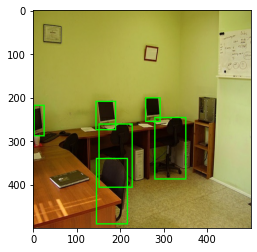

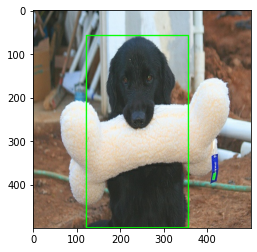

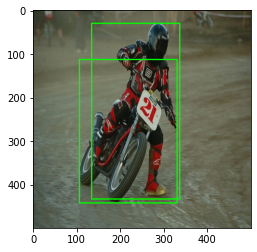

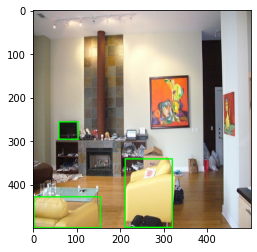

In [ ]:
for i , image in enumerate(img):

    y1 = gt_boxes[i][...,0] * img_size
    x1 = gt_boxes[i][...,1] * img_size
    y2 = gt_boxes[i][...,2] * img_size
    x2 = gt_boxes[i][...,3] * img_size

    gt_box = tf.round(tf.stack([y1, x1, y2, x2], axis=-1))

    image = tf.keras.preprocessing.image.array_to_img(image)
    width, height = image.size
    draw = ImageDraw.Draw(image)
    
    for bbox in gt_box:
        y1, x1, y2, x2 = tf.split(bbox, 4, axis = -1)

        draw.rectangle((x1, y1, x2, y2), outline=(0, 255, 0), width=3)
    
    plt.figure()
    plt.imshow(image)
    plt.show()

## Anchors


In [5]:
feature_map_shape = hyper_params['feature_map_shape']

stride = 1 / feature_map_shape

grid_coords_ctr = tf.cast(tf.range(0, feature_map_shape) / feature_map_shape + stride / 2, dtype=tf.float32)

grid_x_ctr, grid_y_ctr = tf.meshgrid(grid_coords_ctr, grid_coords_ctr) # tf.meshgrid : 공간상에서 격자를 만드는 함수

flat_grid_x_ctr, flat_grid_y_ctr = tf.reshape(grid_x_ctr, (-1, )), tf.reshape(grid_y_ctr, (-1, ))

grid_map = tf.stack([flat_grid_y_ctr, flat_grid_x_ctr, flat_grid_y_ctr, flat_grid_x_ctr], axis=-1)

base_anchors = []
for scale in hyper_params['anchor_scales']:
    scale /= hyper_params['img_size']
    for ratio in hyper_params['anchor_ratios']:
        w = tf.sqrt(scale **2 / ratio)
        h = w * ratio
        base_anchors.append([-h/2, -w/2, h/2, w/2])
base_anchors = tf.cast(base_anchors, dtype=tf.float32)        

anchors = tf.reshape(base_anchors, (1, -1, 4)) + tf.reshape(grid_map, (-1, 1, 4))

anchors = tf.reshape(anchors, (-1, 4))
anchors = tf.clip_by_value(t=anchors, clip_value_min=0, clip_value_max=1) # tf.clip_by_value : min, max값보다 작거나 같은 값을 clip 값으로 대체

In [ ]:
print('anchors shape:',anchors.shape, "(31 X 31 X 3 X 3, coordinates)")
print(anchors[0:3])

anchors shape: (8649, 4) (31 X 31 X 3 X 3, coordinates)
tf.Tensor(
[[0.         0.         0.14412904 0.14412904]
 [0.         0.         0.19714837 0.1066387 ]
 [0.         0.         0.1066387  0.19714837]], shape=(3, 4), dtype=float32)


## Intersection over Union


In [6]:
def generate_iou(anchors, gt_boxes):
    bbox_y1, bbox_x1, bbox_y2, bbox_x2 = tf.split(anchors, 4, axis=-1) 
    gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(gt_boxes, 4, axis=-1) 
    
    bbox_area = tf.squeeze((bbox_y2 - bbox_y1) * (bbox_x2 - bbox_x1), axis=-1) 
    gt_area = tf.squeeze((gt_y2 - gt_y1) * (gt_x2 - gt_x1), axis = -1)
    
    x_top = tf.maximum(bbox_x1, tf.transpose(gt_x1, [0, 2, 1])) 
    y_top = tf.maximum(bbox_y1, tf.transpose(gt_y1, [0, 2, 1]))
    x_bottom = tf.minimum(bbox_x2, tf.transpose(gt_x2, [0, 2, 1]))
    y_bottom = tf.minimum(bbox_y2, tf.transpose(gt_y2, [0, 2, 1]))
    
    intersection_area = tf.maximum(x_bottom - x_top, 0) * tf.maximum(y_bottom - y_top, 0)
    
    union_area = (tf.expand_dims(bbox_area, -1) + tf.expand_dims(gt_area, 1) - intersection_area)
    
    return intersection_area / union_area 

## Bounding box operation


In [7]:
def bbox_to_delta(anchors, gt_boxes):
    bbox_width = anchors[..., 3] - anchors[..., 1]
    bbox_height = anchors[..., 2] - anchors[...,0]
    bbox_ctr_x = anchors[..., 1] + 0.5 * bbox_width
    bbox_ctr_y = anchors[..., 0] + 0.5 * bbox_height
    
    gt_width = gt_boxes[..., 3] - gt_boxes[..., 1]
    gt_height = gt_boxes[..., 2] - gt_boxes[..., 0]
    gt_ctr_x = gt_boxes[..., 1] + 0.5 * gt_width
    gt_ctr_y = gt_boxes[..., 0] + 0.5 * gt_height
    
    bbox_width = tf.where(tf.equal(bbox_width, 0), 1e-3, bbox_width)
    bbox_height = tf.where(tf.equal(bbox_height, 0), 1e-3, bbox_height)
    delta_x = tf.where(tf.equal(gt_width, 0), tf.zeros_like(gt_width), tf.truediv((gt_ctr_x - bbox_ctr_x), bbox_width))
    delta_y = tf.where(tf.equal(gt_height, 0), tf.zeros_like(gt_height), tf.truediv((gt_ctr_y - bbox_ctr_y), bbox_height))
    delta_w = tf.where(tf.equal(gt_width, 0), tf.zeros_like(gt_width), tf.math.log(gt_width / bbox_width))
    delta_h = tf.where(tf.equal(gt_height, 0), tf.zeros_like(gt_height), tf.math.log(gt_height / bbox_height))
    
    return tf.stack([delta_y, delta_x, delta_h, delta_w], axis=-1)

def delta_to_bbox(anchors, bbox_deltas):
    all_anc_width = anchors[..., 3] - anchors[..., 1]
    all_anc_height = anchors[..., 2] - anchors[..., 0]
    all_anc_ctr_x = anchors[..., 1] + 0.5 * all_anc_width
    all_anc_ctr_y = anchors[..., 0] + 0.5 * all_anc_height

    all_bbox_width = tf.exp(bbox_deltas[..., 3]) * all_anc_width
    all_bbox_height = tf.exp(bbox_deltas[..., 2]) * all_anc_height
    all_bbox_ctr_x = (bbox_deltas[..., 1] * all_anc_width) + all_anc_ctr_x
    all_bbox_ctr_y = (bbox_deltas[..., 0] * all_anc_height) + all_anc_ctr_y

    y1 = all_bbox_ctr_y - (0.5 * all_bbox_height)
    x1 = all_bbox_ctr_x - (0.5 * all_bbox_width)
    y2 = all_bbox_height + y1
    x2 = all_bbox_width + x1
    
    return tf.stack([y1, x1, y2, x2], axis=-1)

## RPN Target

In [ ]:
def calculate_rpn_actual_outputs(anchors, gt_boxes, gt_labels, hyper_params, chk_pos_num):
    batch_size = hyper_params['batch_size'] 
    feature_map_shape = hyper_params['feature_map_shape'] 
    anchor_count = hyper_params['anchor_count']  
    total_pos_bboxes = hyper_params['total_pos_bboxes'] 
    total_neg_bboxes = hyper_params['total_neg_bboxes']
    variances = hyper_params['variances'] 
    pos_threshold = hyper_params["pos_threshold"]
    neg_threshold = hyper_params["neg_threshold"]

    iou_map = generate_iou(anchors, gt_boxes)
    #
    max_indices_each_row = tf.argmax(iou_map, axis=2, output_type=tf.int32)
    max_indices_each_column = tf.argmax(iou_map, axis=1, output_type=tf.int32)
    merged_iou_map = tf.reduce_max(iou_map, axis=2) 

    pos_mask = tf.greater(merged_iou_map, pos_threshold)
    chk_pos_num = np.size(np.where(pos_mask[0] == True))
    #
    valid_indices_cond = tf.not_equal(gt_labels, -1)
    
    valid_indices = tf.cast(tf.where(valid_indices_cond), tf.int32)
    
    valid_max_indices = max_indices_each_column[valid_indices_cond]
    #

    scatter_bbox_indices = tf.stack([valid_indices[..., 0], valid_max_indices], 1)
    max_pos_mask = tf.scatter_nd(indices=scatter_bbox_indices, updates=tf.fill((tf.shape(valid_indices)[0], ), True), shape=tf.shape(pos_mask))
    pos_mask = tf.logical_or(pos_mask, max_pos_mask)
    pos_mask = randomly_select_xyz_mask(pos_mask, tf.constant([total_pos_bboxes], dtype=tf.int32))
    #
    pos_count = tf.reduce_sum(tf.cast(pos_mask, tf.int32), axis=-1)
    neg_count = (total_pos_bboxes + total_neg_bboxes) - pos_count
    
    neg_mask = tf.logical_and(tf.less(merged_iou_map, neg_threshold), tf.logical_not(pos_mask))
    neg_mask = randomly_select_xyz_mask(neg_mask, neg_count)
    #
    
    pos_labels = tf.where(pos_mask, tf.ones_like(pos_mask, dtype=tf.float32), tf.constant(-1.0, dtype=tf.float32))
    
    neg_labels = tf.cast(neg_mask, dtype=tf.float32)
    bbox_labels = tf.add(pos_labels, neg_labels)
    gt_boxes_map = tf.gather(params=gt_boxes, indices=max_indices_each_row, batch_dims=1)

    expanded_gt_boxes = tf.where(tf.expand_dims(pos_mask, -1), gt_boxes_map, tf.zeros_like(gt_boxes_map))
    
    bbox_deltas = bbox_to_delta(anchors, expanded_gt_boxes) / variances

    bbox_deltas = tf.reshape(bbox_deltas, (batch_size, feature_map_shape, feature_map_shape, anchor_count* 4))
    bbox_labels = tf.reshape(bbox_labels, (batch_size, feature_map_shape, feature_map_shape, anchor_count))
    
    return bbox_deltas, bbox_labels, chk_pos_num

def randomly_select_xyz_mask(mask, select_xyz):
    maxval = tf.reduce_max(select_xyz) * 10
    random_mask = tf.random.uniform(tf.shape(mask), minval=1, maxval=maxval, dtype=tf.int32)
    multiplied_mask = tf.cast(mask, tf.int32) * random_mask
    sorted_mask = tf.argsort(multiplied_mask, direction="DESCENDING")
    sorted_mask_indices = tf.argsort(sorted_mask)
    selected_mask = tf.less(sorted_mask_indices, tf.expand_dims(select_xyz, 1))
    return tf.logical_and(mask, selected_mask)

## Region Proposal Network


In [8]:
class RPN(Model):
    
    def __init__(self, hyper_params):
        super(RPN, self).__init__()
        self.hyper_params = hyper_params

        self.base_model = VGG16(include_top=False, input_shape=(self.hyper_params["img_size"], 
                                                                self.hyper_params["img_size"],
                                                                3))        

        self.layer = self.base_model.get_layer('block5_conv3').output

        self.feature_extractor = Model(inputs=self.base_model.input, outputs=self.layer)
        self.feature_extractor.trainable = False

        self.conv = Conv2D(filters=512, kernel_size=(3, 3), 
                           activation='relu', padding='same', 
                           name='rpn_conv')

        self.rpn_cls_output = Conv2D(filters=self.hyper_params['anchor_count'], 
                                     kernel_size=(1, 1), 
                                     activation='sigmoid', 
                                     name='rpn_cls')

        self.rpn_reg_output = Conv2D(filters=self.hyper_params['anchor_count']*4, 
                                     kernel_size=(1,1), 
                                     activation='linear', 
                                     name='rpn_reg')

    def call(self,inputs):
        feature_map = self.feature_extractor(inputs) 
        x = self.conv(feature_map)
        cls = self.rpn_cls_output(x)
        reg = self.rpn_reg_output(x)
        return [reg, cls, feature_map]

rpn_model = RPN(hyper_params)
input_shape = (None, 500, 500, 3)
rpn_model.build(input_shape)
rpn_model.load_weights("/content/drive/MyDrive/faster_rcnn/rpn_weights/weights")

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
rpn_reg_output, rpn_cls_output, feature_map = rpn_model.predict(img)

## RPN Train

In [ ]:
optimizer1 = keras.optimizers.Adam(learning_rate=1e-5)

@tf.function
def train_step1(img, bbox_deltas, bbox_labels, hyper_params):
    with tf.GradientTape(persistent=True) as tape:
        '''RPN'''
        rpn_reg_output, rpn_cls_output, feature_map = rpn_model(img)
        
        rpn_reg_loss = region_reg_loss(rpn_reg_output, bbox_deltas, bbox_labels, hyper_params)
        rpn_cls_loss = region_cls_loss(rpn_cls_output, bbox_labels)
        rpn_loss = rpn_reg_loss + rpn_cls_loss
        
    grads_rpn = tape.gradient(rpn_loss, rpn_model.trainable_weights)

    optimizer1.apply_gradients(zip(grads_rpn, rpn_model.trainable_weights))

    return rpn_reg_loss, rpn_cls_loss, rpn_reg_output, rpn_cls_output, feature_map


def region_reg_loss(pred, bbox_deltas, bbox_labels, hyper_params):
    #
    pred = tf.reshape(pred, (hyper_params["batch_size"], hyper_params['feature_map_shape'],
                                         hyper_params['feature_map_shape'],
                                         hyper_params['anchor_count'], 4))
    bbox_deltas = tf.reshape(bbox_deltas, (hyper_params["batch_size"], hyper_params['feature_map_shape'],
                                                       hyper_params['feature_map_shape'],
                                                       hyper_params['anchor_count'], 4))

    total_anchors_loc = hyper_params['feature_map_shape'] * hyper_params['feature_map_shape']
    
    tune_param = total_anchors_loc / (hyper_params["total_pos_bboxes"] + hyper_params["total_neg_bboxes"])

    loss_fn = tf.losses.Huber(reduction=tf.losses.Reduction.NONE)

    loss_for_all = loss_fn(bbox_deltas, pred)
    
    pos_cond = tf.equal(bbox_labels, tf.constant(1.0))
    
    pos_mask = tf.cast(pos_cond, dtype=tf.float32)

    loc_loss = tf.reduce_sum(pos_mask * loss_for_all)


    return loc_loss * tune_param / total_anchors_loc

def region_cls_loss(pred, bbox_labels):

    indices = tf.where(tf.not_equal(bbox_labels, tf.constant(-1.0, dtype = tf.float32)))
    
    target = tf.gather_nd(bbox_labels, indices)

    output = tf.gather_nd(pred, indices)

    lf = tf.losses.BinaryCrossentropy()
    return lf(target, output)


## RPN result

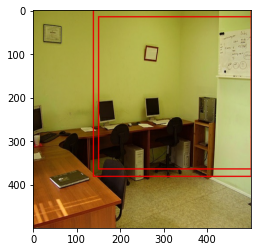

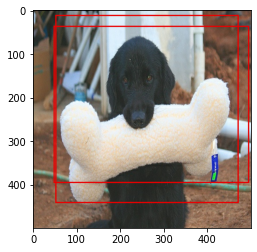

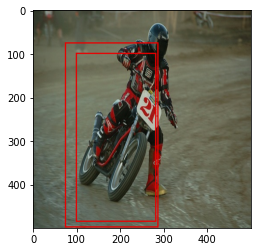

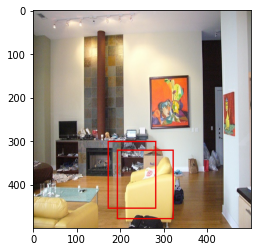

In [ ]:
total_anchors = anchors.shape[0]
rpn_deltas = tf.reshape(rpn_reg_output, shape=(batch_size, total_anchors, 4)) 
rpn_deltas *= hyper_params["variances"]
rpn_scores = tf.reshape(rpn_cls_output, shape=(batch_size, total_anchors))

rpn_bbox = delta_to_bbox(anchors, rpn_deltas)

for i , image in enumerate(img):
    
    y1 = rpn_bbox[i][...,0] * img_size
    x1 = rpn_bbox[i][...,1] * img_size
    y2 = rpn_bbox[i][...,2] * img_size
    x2 = rpn_bbox[i][...,3] * img_size

    denormalized_box = tf.round(tf.stack([y1, x1, y2, x2], axis=-1))

    _, top_indices = tf.nn.top_k(rpn_scores[i], 2)
    #
    selected_rpn_bboxes = tf.gather(denormalized_box, top_indices, batch_dims=0)

    #
    colors = 234 

    image = tf.keras.preprocessing.image.array_to_img(image)
    width, height = image.size
    draw = ImageDraw.Draw(image)
    
    for bbox in selected_rpn_bboxes:
        y1, x1, y2, x2 = tf.split(bbox, 4, axis = -1)

        draw.rectangle((x1, y1, x2, y2), outline=colors, width=3)
    
    plt.figure()
    plt.imshow(image)
    plt.show()


## Non-Maximum Suppression


In [9]:
class RoIBBox(Layer):
    
    def __init__(self, anchors, hyper_params, test=False, **kwargs):
        super(RoIBBox, self).__init__(**kwargs)
        self.hyper_params = hyper_params
        self.anchors = tf.constant(anchors, dtype=tf.float32)
        self.test = test

    def get_config(self):
        config = super(RoIBBox, self).get_config()
        config.update({"hyper_params": self.hyper_params, "anchors": self.anchors.numpy()})
        return config

    def call(self, inputs):
        rpn_bbox_deltas = inputs[0]
        rpn_probs = inputs[1]
        anchors = self.anchors
        #
        pre_nms_topn = self.hyper_params["pre_nms_topn"]
        post_nms_topn = self.hyper_params["train_nms_topn"]
        if self.test == True: post_nms_topn = self.hyper_params["test_nms_topn"]

        nms_iou_threshold = self.hyper_params["nms_iou_threshold"]

        variances = self.hyper_params["variances"]

        total_anchors = anchors.shape[0]
        batch_size = tf.shape(rpn_bbox_deltas)[0]
        rpn_bbox_deltas = tf.reshape(rpn_bbox_deltas, (batch_size, total_anchors, 4))
        rpn_probs = tf.reshape(rpn_probs, (batch_size, total_anchors))
        #
        rpn_bbox_deltas *= variances
        #
        rpn_bboxes = delta_to_bbox(anchors, rpn_bbox_deltas)

        _, pre_indices = tf.nn.top_k(rpn_probs, pre_nms_topn)
        #
        pre_roi_bboxes = tf.gather(rpn_bboxes, pre_indices, batch_dims=1)
        pre_roi_probs = tf.gather(rpn_probs, pre_indices, batch_dims=1)
        #
        pre_roi_bboxes = tf.reshape(pre_roi_bboxes, (batch_size, pre_nms_topn, 1, 4))
        pre_roi_probs = tf.reshape(pre_roi_probs, (batch_size, pre_nms_topn, 1))
        #
        
        roi_bboxes, roi_scores, _, _ = tf.image.combined_non_max_suppression(pre_roi_bboxes, pre_roi_probs,
                                                            max_output_size_per_class=post_nms_topn,
                                                            max_total_size = post_nms_topn,
                                                            iou_threshold=nms_iou_threshold)
        #
        return roi_bboxes, roi_scores
        
NMS = RoIBBox(anchors, hyper_params, test=True, name='roi_bboxes')

In [ ]:
roi_bboxes, roi_scores = NMS([rpn_reg_output, rpn_cls_output, gt_labels])

## RPN result after NMS

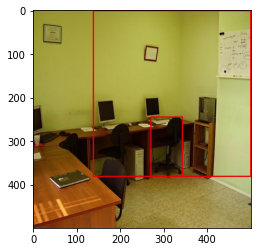

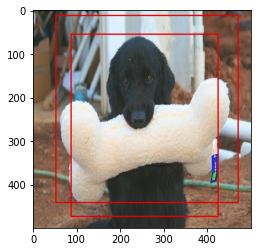

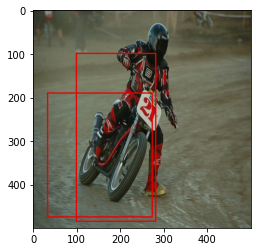

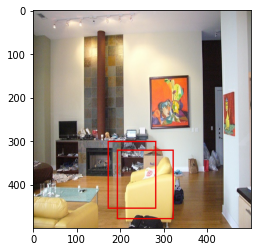

In [ ]:
for i, image in enumerate(img):

    y1 = roi_bboxes[i][...,0] * img_size
    x1 = roi_bboxes[i][...,1] * img_size
    y2 = roi_bboxes[i][...,2] * img_size
    x2 = roi_bboxes[i][...,3] * img_size

    denormalized_box = tf.round(tf.stack([y1, x1, y2, x2], axis=-1))

    _, top_indices = tf.nn.top_k(roi_scores[i], 2)
    #
    selected_rpn_bboxes = tf.gather(denormalized_box, top_indices, batch_dims=0)

    #
    colors = 234 

    image = tf.keras.preprocessing.image.array_to_img(image)
    width, height = image.size
    draw = ImageDraw.Draw(image)
    
    for bbox in selected_rpn_bboxes:
        y1, x1, y2, x2 = tf.split(bbox, 4, axis = -1)

        draw.rectangle((x1, y1, x2, y2), outline=colors, width=3)
    
    plt.figure()
    plt.imshow(image)
    plt.show()

## RoI Pooling


In [10]:
class RoIPooling(Layer):
    #
    def __init__(self, hyper_params, **kwargs):
        super(RoIPooling, self).__init__(**kwargs)
        self.hyper_params = hyper_params
    #
    def get_config(self):
        config = super(RoIPooling, self).get_config()
        config.update({"hyper_params": self.hyper_params})
        return config
    #
    def call(self, inputs):
        feature_map = inputs[0]
        roi_bboxes = inputs[1]
        pooling_size = self.hyper_params["pooling_size"]
        batch_size, total_bboxes = tf.shape(roi_bboxes)[0], tf.shape(roi_bboxes)[1]
        #
        row_size = batch_size * total_bboxes
        #
        pooling_bbox_indices = tf.tile(tf.expand_dims(tf.range(batch_size), axis=1), (1, total_bboxes))
        pooling_bbox_indices = tf.reshape(pooling_bbox_indices, (-1, ))
        pooling_bboxes = tf.reshape(roi_bboxes, (row_size, 4))
        # (roi_1500 * batch_size_4, bbox_coordinate_4)
        #

        pooling_feature_map = tf.image.crop_and_resize(
            feature_map,
            pooling_bboxes,
            pooling_bbox_indices,
            pooling_size
        ) # (roi_1500 * batch_size_4, pooling_size, pooling_size, feature_map_channel_512)
        final_pooling_feature_map = tf.reshape(pooling_feature_map, (batch_size,
                                                                     total_bboxes,
                                                                     pooling_feature_map.shape[1],
                                                                     pooling_feature_map.shape[2],
                                                                     pooling_feature_map.shape[3]))
        #
        return final_pooling_feature_map

Pooling = RoIPooling(hyper_params, name="roi_pooling")

In [ ]:
pooled_roi = Pooling([feature_map, roi_bboxes])

## DTN Target

In [ ]:
class RoIDelta(Layer):
    def __init__(self, hyper_params, **kwargs):
        super(RoIDelta, self).__init__(**kwargs)
        self.hyper_params = hyper_params
        
    def get_config(self):
        config = super(RoIDelta, self).get_config()
        config.update({"hyper_params": self.hyper_params})
        return config
    
    def call(self, inputs):
        roi_bboxes = inputs[0]
        gt_boxes = inputs[1]
        gt_labels = inputs[2]

        background = self.hyper_params["background"]
        total_labels = self.hyper_params["total_labels"]
        total_pos_bboxes = self.hyper_params["total_pos_bboxes"]
        total_neg_bboxes = self.hyper_params["total_neg_bboxes"]
        variances = self.hyper_params["variances"]
        # batch_size, total_bboxes = tf.shape(roi_bboxes)[0], tf.shape(roi_bboxes)[1]
        #
        iou_map = rpn_utils.generate_iou(roi_bboxes, gt_boxes)
        #
        max_indices_each_gt_box = tf.argmax(iou_map, axis=2, output_type=tf.int32)
        # 1500개의 roi_bbox 와의 iou가 가장 큰 gtbox 인덱스
        merged_iou_map = tf.reduce_max(iou_map, axis=2)
        # 1500개의 roi_bbox 와의 iou가 가장 큰 gtbox 의 iou
        pos_mask = tf.greater(merged_iou_map, 0.5)
        # sum(sum(tf.cast(pos_mask, tf.int32)))
        pos_mask = rpn_utils.randomly_select_xyz_mask(pos_mask, tf.constant([total_pos_bboxes], dtype=tf.int32))
        #
        neg_mask = tf.logical_and(tf.less(merged_iou_map, 0.5), tf.greater(merged_iou_map, 0.1))
        # sum(sum(tf.cast(neg_mask, tf.int32)))
        neg_mask = rpn_utils.randomly_select_xyz_mask(neg_mask, tf.constant([total_neg_bboxes], dtype=tf.int32))
        #
        gt_boxes_map = tf.gather(gt_boxes, max_indices_each_gt_box, batch_dims=1)
        expanded_gt_boxes = tf.where(tf.expand_dims(pos_mask, axis=-1), gt_boxes_map, tf.zeros_like(gt_boxes_map))
        #
        gt_labels_map = tf.gather(gt_labels, max_indices_each_gt_box, batch_dims=1)
        # 1500개의 roi_bbox 와의 iou가 가장 큰 gtbox 의 class label 
        pos_gt_labels = tf.where(pos_mask, gt_labels_map, tf.constant(-1, dtype=tf.int32))
        neg_gt_labels = tf.cast(neg_mask, dtype=tf.int32)

        expanded_gt_labels = pos_gt_labels + neg_gt_labels # IoU 가 ~0.1 은 -1, 0.1~0.5 인 것 중 128개는 0, 0.5~ 중 128개는 1 이상의 클래스 나머지는 -1
        if background == False:
            expanded_gt_labels = pos_gt_labels
        #
        roi_bbox_deltas = rpn_utils.bbox_to_delta(roi_bboxes, expanded_gt_boxes) / variances
        #
        roi_bbox_labels = tf.one_hot(expanded_gt_labels, total_labels)
        scatter_indices = tf.tile(tf.expand_dims(roi_bbox_labels, -1), (1, 1, 1, 4))
        roi_bbox_deltas = scatter_indices * tf.expand_dims(roi_bbox_deltas, -2)

        return roi_bbox_deltas, roi_bbox_labels

## Detection Network


In [11]:
class Recog(Model):
    def __init__(self, hyper_params):
        super(Recog, self).__init__()
        self.hyper_params = hyper_params
        #
        self.FC1 = TimeDistributed(Flatten(), name='frcnn_flatten')
        self.FC2 = TimeDistributed(Dense(4096, activation='relu'), name='frcnn_fc1')
        self.FC3 = TimeDistributed(Dropout(0.5), name='frcnn_dropout1')
        self.FC4 = TimeDistributed(Dense(4096, activation='relu'), name='frcnn_fc2')
        self.FC5 = TimeDistributed(Dropout(0.5), name='frcnn_dropout2')
        #
        self.cls = TimeDistributed(Dense(self.hyper_params['total_labels'], 
                                         activation='softmax'), 
                                         name='frcnn_cls')
        self.reg = TimeDistributed(Dense(self.hyper_params['total_labels'] * 4, 
                                         activation='linear'), 
                                         name='frcnn_reg')
        if hyper_params["dtn_with_binary"] == True:
            self.cls = TimeDistributed(Dense(self.hyper_params['total_labels'],
                                             activation='sigmoid'),
                                       name='frcnn_cls')

    def call(self, inputs):
        fc1 = self.FC1(inputs)
        fc2 = self.FC2(fc1)
        fc3 = self.FC3(fc2)
        fc4 = self.FC4(fc3)
        fc5 = self.FC5(fc4)
        cls = self.cls(fc5)
        reg = self.reg(fc5)
        return [reg, cls]
        
frcnn_model = Recog(hyper_params)
input_shape = (None, hyper_params['train_nms_topn'], 7, 7, 512)
frcnn_model.build(input_shape)
frcnn_model.load_weights("/content/drive/MyDrive/faster_rcnn/frcnn_weights/weights")

In [ ]:
pred_deltas, pred_label_probs = frcnn_model.predict(pooled_roi)

## DTN train

In [ ]:

@tf.function
def train_step2(pooled_roi, roi_delta, dtn_with_binary):
    with tf.GradientTape(persistent=True) as tape:
        '''Recognition'''
        frcnn_pred = frcnn_model(pooled_roi, training=True)
        
        frcnn_reg_loss = loss_utils.dtn_reg_loss(frcnn_pred[0], roi_delta[0], roi_delta[1], hyper_params)
        frcnn_cls_loss = loss_utils.dtn_cls_loss(frcnn_pred[1], roi_delta[1])
        if dtn_with_binary == True:
            frcnn_cls_loss = loss_utils.dtn_cls_binary(frcnn_pred[1], roi_delta[1])
        frcnn_loss = frcnn_reg_loss + frcnn_cls_loss

    grads_frcnn = tape.gradient(frcnn_loss, frcnn_model.trainable_weights)
    optimizer2.apply_gradients(zip(grads_frcnn, frcnn_model.trainable_weights))

    return frcnn_reg_loss, frcnn_cls_loss


def dtn_reg_loss(pred, frcnn_reg_actuals, frcnn_cls_actuals, hyper_params):

    pred = tf.reshape(pred, (hyper_params["batch_size"], hyper_params['train_nms_topn'],
                                  hyper_params['total_labels'],4))
    
    frcnn_reg_actuals = tf.reshape(frcnn_reg_actuals, (hyper_params["batch_size"], hyper_params['train_nms_topn'],
                                  hyper_params['total_labels'],4))
    
    loss_fn = tf.losses.Huber(reduction=tf.losses.Reduction.NONE)
    
    loss_for_all = loss_fn(frcnn_reg_actuals, pred)
    
    pos_cond = tf.equal(frcnn_cls_actuals, tf.constant(1.0))
    
    pos_mask = tf.cast(pos_cond, dtype=tf.float32)
    
    loc_loss = tf.reduce_sum(pos_mask * loss_for_all) 
    
    total_pos_bboxes = tf.reduce_sum(pos_mask)
    
    return loc_loss / total_pos_bboxes * 0.5


def dtn_cls_loss(pred, true):

    loss_for_all = -tf.math.reduce_sum(true * tf.math.log(pred + 1e-7), axis=-1)

    cond = tf.reduce_any(tf.not_equal(true, tf.constant(0.0)), axis=-1)

    mask = tf.cast(cond, dtype=tf.float32)
    
    conf_loss = tf.reduce_sum(mask * loss_for_all)

    total_boxes = tf.maximum(1.0, tf.reduce_sum(mask))

    return conf_loss / total_boxes

## Decode
test

In [12]:
class Decoder(Layer):
    def __init__(self, hyper_params, max_total_size=200, score_threshold=0.9, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.variances = hyper_params["variances"]
        self.total_labels = hyper_params["total_labels"]
        self.max_total_size = max_total_size
        self.score_threshold = score_threshold
        
    def get_config(self):
        config = super(Decoder, self).get_config()
        config.update({
            "variances" : self.variances,
            "total_labels": self.total_labels,
            "max_total_size": self.max_total_size,
            "score_threshold" : self.score_threshold
        })
        return config

    def call(self, inputs):
        roi_bboxes = inputs[0]
        pred_deltas = inputs[1]
        pred_label_probs = inputs[2]
        batch_size = tf.shape(pred_deltas)[0]

        pred_deltas = tf.reshape(pred_deltas, (batch_size, -1, self.total_labels, 4))
        pred_deltas *= self.variances

        expanded_roi_bboxes = tf.tile(tf.expand_dims(roi_bboxes, -2), (1, 1, self.total_labels, 1))
        
        pred_bboxes = delta_to_bbox(expanded_roi_bboxes, pred_deltas)

        pred_labels_map = tf.expand_dims(tf.argmax(pred_label_probs, -1), -1)
        pred_labels = tf.where(tf.not_equal(pred_labels_map, 0), pred_label_probs, tf.zeros_like(pred_label_probs))
        
        final_bboxes, final_scores, final_labels, _ = tf.image.combined_non_max_suppression(
                            pred_bboxes, pred_labels,
                            max_output_size_per_class = self.max_total_size,
                            max_total_size = self.max_total_size,
                            score_threshold=self.score_threshold
                        )
        return final_bboxes, final_labels, final_scores
    
decode = Decoder(hyper_params, name='decoder')

In [ ]:
final_bboxes, final_labels, final_scores = decode([roi_bboxes, pred_deltas, pred_label_probs])

## DTN result

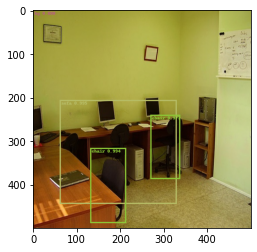

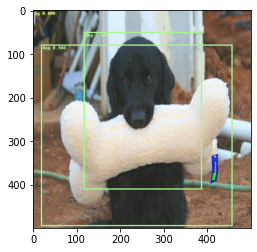

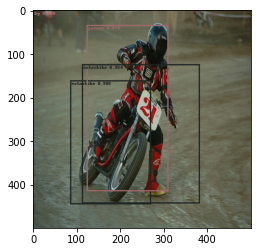

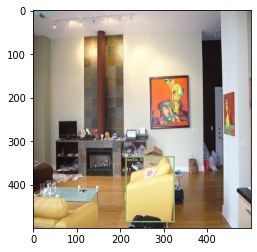

In [ ]:
for i , image in enumerate(img):

        y1 = final_bboxes[i][...,0] * img_size
        x1 = final_bboxes[i][...,1] * img_size
        y2 = final_bboxes[i][...,2] * img_size
        x2 = final_bboxes[i][...,3] * img_size

        denormalized_box = tf.round(tf.stack([y1, x1, y2, x2], axis=-1))

        colors = tf.random.uniform((len(labels), 4), maxval=256, dtype=tf.int32)

        image = tf.keras.preprocessing.image.array_to_img(image)
        width, height = image.size
        draw = ImageDraw.Draw(image)
        
        for index, bbox in enumerate(denormalized_box):
            y1, x1, y2, x2 = tf.split(bbox, 4, axis = -1)
            width = x2 - x1
            height = y2 - y1
            # if width <= 0 or height <=0:
            #     continue
            final_labels_ = tf.reshape(final_labels[i], shape=(200,))
            final_scores_ = tf.reshape(final_scores[i], shape=(200,))
            label_index = int(final_labels_[index])
            color = tuple(colors[label_index].numpy())
            label_text = "{0} {1:0.3f}".format(labels[label_index], final_scores_[index])
            draw.text((x1 + 4, y1 + 2), label_text, fill=color)
            draw.rectangle((x1, y1, x2, y2), outline=color, width=3)
        
        plt.figure()
        plt.imshow(image)
        plt.show()

## Test

In [13]:
test_id = -1
batch_data = np.array([np.load(test_dir + test_file_name[test_id] + ".npy", allow_pickle=True)])
img, gt_boxes, gt_labels = preprocessing(batch_data, 1, hyper_params["img_size"], hyper_params["img_size"], evaluate=False)

Time taken: 263.32ms
FPS: 3.80fps


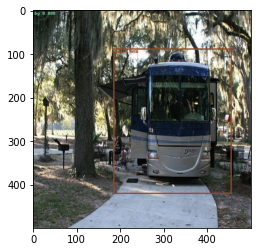

In [18]:
start_time = time.time()
rpn_reg_output, rpn_cls_output, feature_map = rpn_model.predict(img)
roi_bboxes, roi_scores = NMS([rpn_reg_output, rpn_cls_output, gt_labels])
pooled_roi = Pooling([feature_map, roi_bboxes])
pred_deltas, pred_label_probs = frcnn_model.predict(pooled_roi)
final_bboxes, final_labels, final_scores = decode([roi_bboxes, pred_deltas, pred_label_probs])
end_time = time.time()
print("Time taken: %.2fms" % (float(end_time - start_time)*1000))
print("FPS: %.2ffps" % (1000 / (float(end_time - start_time)*1000)))

for i , image in enumerate(img):

        y1 = final_bboxes[i][...,0] * img_size
        x1 = final_bboxes[i][...,1] * img_size
        y2 = final_bboxes[i][...,2] * img_size
        x2 = final_bboxes[i][...,3] * img_size

        denormalized_box = tf.round(tf.stack([y1, x1, y2, x2], axis=-1))

        colors = tf.random.uniform((len(labels), 4), maxval=256, dtype=tf.int32)

        image = tf.keras.preprocessing.image.array_to_img(image)
        width, height = image.size
        draw = ImageDraw.Draw(image)
        
        for index, bbox in enumerate(denormalized_box):
            y1, x1, y2, x2 = tf.split(bbox, 4, axis = -1)
            width = x2 - x1
            height = y2 - y1

            final_labels_ = tf.reshape(final_labels[i], shape=(200,))
            final_scores_ = tf.reshape(final_scores[i], shape=(200,))
            label_index = int(final_labels_[index])
            color = tuple(colors[label_index].numpy())
            label_text = "{0} {1:0.3f}".format(labels[label_index], final_scores_[index])
            draw.text((x1 + 4, y1 + 2), label_text, fill=color)
            draw.rectangle((x1, y1, x2, y2), outline=color, width=3)
        
        plt.figure()
        plt.imshow(image)
        plt.show()